# Unified batch and streaming ingestion API
### Storage Write API - https://cloud.google.com/bigquery/docs/write-api
### BigQuery Storage V1 -https://cloud.google.com/bigquery/docs/reference/storage/rpc/google.cloud.bigquery.storage.v1
##### "Pending" mode chosen from the available three modes - ( Commited , Pending , Buffered )

### BigQuery Storage API V1 Methods - https://cloud.google.com/bigquery/docs/reference/storage/rpc

In [1]:
import sys
#!{sys.executable} -m pip install --upgrade google-cloud-bigquery-storage

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
!{sys.executable} -m pip show google-cloud-bigquery-storage

Name: google-cloud-bigquery-storage
Version: 2.11.0
Summary: BigQuery Storage API API client library
Home-page: https://github.com/googleapis/python-bigquery-storage
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: d:\python\python39\lib\site-packages
Requires: google-api-core, libcst, proto-plus
Required-by: 


In [4]:
from google.cloud import bigquery
from google.cloud.bigquery import Table
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

from google.cloud import bigquery_storage_v1
from google.cloud.bigquery_storage_v1 import BigQueryWriteClient
from google.cloud.bigquery_storage_v1 import types
from google.cloud.bigquery_storage_v1 import writer
from google.protobuf import descriptor_pb2

### Make Proto2 stubs with proto2 messages , since Storage API V1 only support protobuf V2

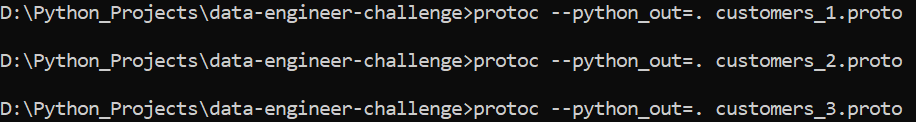

In [5]:
project_id = 'bigquery-project-32089'
dataset_id = 'customers_dataset'
table_id = 'customer_records'
dataset_full_name = f"{project_id}.{dataset_id}"
table_full_name = f"{project_id}.{dataset_id}.{table_id}"

In [6]:
import json
from collections import namedtuple

import customers_1_pb2
import customers_2_pb2
import customers_3_pb2

In [7]:
def customerRecordsDecoder(customerDict):
    return namedtuple('X', customerDict.keys(), rename=True)(*customerDict.values())

def create_row_data(customer):
    row = customers_1_pb2.Customers_1_Message()    
    row._id = customer._0    
    row.index = customer.index
    row.guid = customer.guid
    row.isActive = customer.isActive
    row.age = customer.age
    row.eyeColor = customer.eyeColor
    row.name = customer.name
    row.gender = customer.gender
    row.company = customer.company
    row.email = customer.email
    row.phone = customer.phone
    row.address = customer.address
    row.about = customer.about
    row.registered = customer.registered
    row.latitude = customer.latitude
    row.longitude = customer.longitude
    for i in customer.tags:
        row.tags.append(i)
        
    fri = row.Friends()
    for friend in customer.friends:
        fri.id = friend.id
        fri.name = friend.name
        row.friends.append(fri)        
    
    row.greeting = customer.greeting
    row.favoriteFruit = customer.favoriteFruit
    return row.SerializeToString()


def append_rows_pending(project_id: str, dataset_id: str, table_id: str):
    
    linesx = open(r'.\data\customers_1.json').read().splitlines()    

    """Create a write stream, write data, and commit the stream."""
    write_client = bigquery_storage_v1.BigQueryWriteClient()
    
    parent = write_client.table_path(project_id, dataset_id, table_id)
    write_stream = types.WriteStream()

    # When creating the stream, choose the type. Use the PENDING type to wait
    # until the stream is committed before it is visible. See:
    
    write_stream.type_ = types.WriteStream.Type.PENDING
    write_stream = write_client.create_write_stream(
        parent=parent, write_stream=write_stream
    )
    stream_name = write_stream.name

    # Create a template with fields needed for the first request.
    request_template = types.AppendRowsRequest()

    # The initial request must contain the stream name.
    request_template.write_stream = stream_name

    # So that BigQuery knows how to parse the serialized_rows, generate a
    # protocol buffer representation of your message descriptor.
    proto_schema = types.ProtoSchema()
    proto_descriptor = descriptor_pb2.DescriptorProto()
    ##customer_record_pb2.CustomerRecord.DESCRIPTOR.CopyToProto(proto_descriptor)
    customers_1_pb2.Customers_1_Message.DESCRIPTOR.CopyToProto(proto_descriptor)
    proto_schema.proto_descriptor = proto_descriptor
    proto_data = types.AppendRowsRequest.ProtoData()
    proto_data.writer_schema = proto_schema
    request_template.proto_rows = proto_data

    # Some stream types support an unbounded number of requests. Construct an
    # AppendRowsStream to send an arbitrary number of requests to a stream.
    append_rows_stream = writer.AppendRowsStream(write_client, request_template)

    # Create a batch of row data by appending proto2 serialized bytes to the
    # serialized_rows repeated field.
    proto_rows = types.ProtoRows()    
   
    count = 0
    #request = types.AppendRowsRequest()
    # Strips the newline character
    for line in linesx:        
        ### request.offset = count
        count += 1        
        # Parse JSON into an object with attributes corresponding to dict keys.
        customer = json.loads(line.strip(), object_hook=customerRecordsDecoder)    
        proto_rows.serialized_rows.append(create_row_data(customer))
        ## proto_rows.serialized_rows.append(create_row_data(2, "Bob"))
        
    # Set an offset to allow resuming this stream if the connection breaks.
    # Keep track of which requests the server has acknowledged and resume the
    # stream at the first non-acknowledged message. If the server has already
    # processed a message with that offset, it will return an ALREADY_EXISTS
    # error, which can be safely ignored.
    #
    # The first request must always have an offset of 0.
    request = types.AppendRowsRequest()
    request.offset = 0
    proto_data = types.AppendRowsRequest.ProtoData()
    proto_data.rows = proto_rows
    request.proto_rows = proto_data
    response_future_1 = append_rows_stream.send(request)
    
    # Send another batch.
    ## proto_rows = types.ProtoRows()
    ## proto_rows.serialized_rows.append(create_row_data(3, "Charles"))

    # Since this is the second request, you only need to include the row data.
    # The name of the stream and protocol buffers DESCRIPTOR is only needed in
    # the first request.
    ## request = types.AppendRowsRequest()
    ## proto_data = types.AppendRowsRequest.ProtoData()
    ## proto_data.rows = proto_rows
    ## request.proto_rows = proto_data

    # Offset must equal the number of rows that were previously sent.
    ## request.offset = 2
    ## response_future_2 = append_rows_stream.send(request)

    print(response_future_1.result())
    ## print(response_future_2.result())

    # Shutdown background threads and close the streaming connection.
    append_rows_stream.close()

    # A PENDING type stream must be "finalized" before being committed. No new
    # records can be written to the stream after this method has been called.
    write_client.finalize_write_stream(name=write_stream.name)

    # Commit the stream you created earlier.
    batch_commit_write_streams_request = types.BatchCommitWriteStreamsRequest()
    batch_commit_write_streams_request.parent = parent
    batch_commit_write_streams_request.write_streams = [write_stream.name]
    write_client.batch_commit_write_streams(batch_commit_write_streams_request)

    print(f"Writes to stream: '{write_stream.name}' have been committed.")


## Append rows pending

In [8]:
append_rows_pending(project_id, dataset_id, table_id)

append_result {
  offset {
  }
}

Writes to stream: 'projects/bigquery-project-32089/datasets/customers_dataset/tables/customer_records/streams/Cic3NDFmNjY4Mi0wMDAwLTIzM2ItOWVjZi0wMDFhMTE0MzhhZjg6czI' have been committed.
